## Interactive plots in Jupyter notebooks with matplotlib and ipywidgets
## matplotlib and the inline backend

Author: DVC  
Date: 01/12/2020   


### Using the inline backend with a GUI ?

The matplotlib inline backend is described as a **non-GUI** backend.  So, why do we insist on using it with a (simple) GUI ?    
- it is the most commonly used backend 
- it is probably the only backend that behaves consistently across platforms  
- what works with the inline backend is almost guaranteed to work with any other backend
- we often need something more fancy than just typing in cells as provided natively in our Jupyter notebooks

What are the opportunities and limitations with the inline backend ?  
- the basic (ipy)widgets work fine in the inline backend, creating some possibilities
- figures are rendered as png's in the output cell and its components are not accessible after being rendered
- interactivity can only be simulated by redrawing the full figure after each change
    + this is not an issue with slow updates of the controls
    + flickering and visual glitches from the clear-and-redraw cycle are inevitable
    + computational load quickly increases for complex applications
    + be aware that a figure is NOT closed after rendering

In [2]:
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, interactive, interactive_output
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import IPython.display as ipd
import time


def my_sine(x, w, amp, phi):
    return amp*np.sin(w * (x-phi))
#
def synth(sigtype='sin', freq=200.0, Fs=8000, Tmax=0.5):
    t = np.linspace(0.0, Tmax, int(Tmax*Fs), endpoint=False)
    if sigtype == 'sin':
        x = np.sin(2.0*np.pi*freq*t)
    elif sigtype == 'square':
        x = signal.square(2.0*np.pi*freq*t)
    elif sigtype == 'sawtooth':
        x = signal.sawtooth(2.0*np.pi*freq*t)
    else:
        print( 'signal: Unrecognized signal type')
    return x, t

plt.close('all')

In [3]:
# any of these could be useful during debugging, but not needed if all is running fine
#
#%matplotlib --list
#ipd.set_matplotlib_close(close=True)
#plt.close('all')
#import matplotlib as mpl
#mpl.is_interactive()

### Dynamic Plotting with matplotlib
The example below gives a dynamic plot of a sine   
This works fine (fig.canvas.draw() and flush_events()) with Qt5, tk, .. backends  but surprisingly not with the widget backend 
It does not work with inline

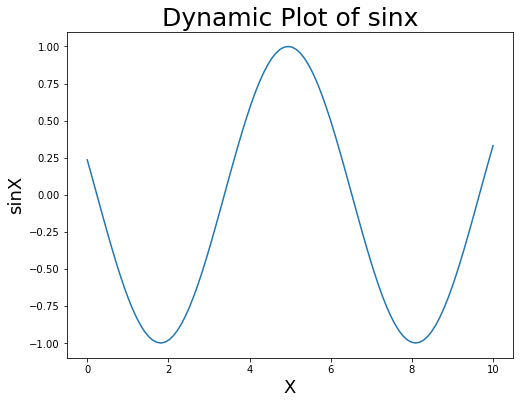

In [4]:
import numpy as np
import time
import matplotlib.pyplot as plt

x = np.linspace(0, 10, 100)
y = np.cos(x)

# plt.ion()

figure, ax = plt.subplots(figsize=(8,6))
line1, = ax.plot(x, y)

plt.title("Dynamic Plot of sinx",fontsize=25)

plt.xlabel("X",fontsize=18)
plt.ylabel("sinX",fontsize=18)

for p in range(100):
    updated_y = np.cos(x-0.05*p)
    
    line1.set_xdata(x)
    line1.set_ydata(updated_y)
    
    figure.canvas.draw()
    
    figure.canvas.flush_events()
    time.sleep(0.1)

### 1. Plotting in a loop

Also with the inline backend it is possible to make dynamic plots - somewhat contrary to expectations   
It requires taking control of the display() functionm either explicitly or via some interactive() widget   

### Refreshing Plots by display control over clearing, flickering and double plots
    
+ With a cycle of plots it is essential to take control over the output display and not rely on default mpl rendering.
+ To avoid flickering it is essential to do the clear_output(wait=True) which waits with clearing the cell output till new output is available 
+ This wait works fine as long as a single plot is refreshed over and over again;  however if the displaying consists of multiple renderings, then flickering will still be the case
+ By default the result of mpl ploting is rendered at the end of execution of a cell; in the loop below where ther is explicit rendering, this results in double output of the last plot.  This is masked here by clearing the display before finalizing  (a bit clumsy, but don't know of a better solution)
+ You can manipulate the behavior with flags:   
    - CLEAR_FIG:  
        + The matplotlib figure is cleared with each cycle
        + if you don't clear the matplotlib figure, then new line plots are added to the figure
    - CLEAR_DISPLAY: 
        + The IPython cell output is cleared with each cycle
        + if you don't clear the display, then new figures (png's) are added to the cell output
    - PRINT:
        + extra print statements are added to the output, this disturbs stability of the rendering


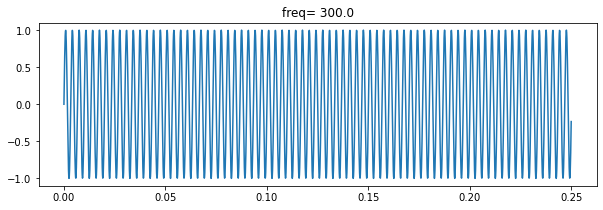

In [5]:
# The non interactive baseline, using the declarative interface
CLEAR_FIG = True
CLEAR_DISPLAY = True
PRINT = False
SLEEP = 1

x = np.linspace(0, 2 * np.pi, 100)
fig =  plt.figure(figsize=(10,3))

def update_plot(freq):
    y,t = synth(sigtype='sin',freq=freq,Fs=8000,Tmax=0.25)
    
    if CLEAR_FIG:  plt.clf()
    plt.plot(t,y, color='C0')
    plt.title('freq= %.1f' % freq)

    # wait=True waits to clear till new output is available
    if CLEAR_DISPLAY: ipd.clear_output(wait=True)
    # plt.show()
    ipd.display(fig)
    
for i in range(1,4):
    freq = 100.*i
    update_plot(freq)
    if PRINT: 
        time.sleep(SLEEP)
        print('finished',i)
    time.sleep(SLEEP)
    
if CLEAR_DISPLAY: ipd.clear_output(wait=True)

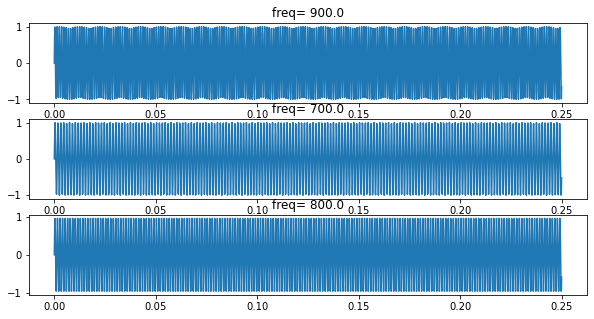

In [6]:
# The non interactive baseline using the OO interface
CLEAR_FIG = True
CLEAR_DISPLAY = True
PRINT = False
SLEEP = 1

x = np.linspace(0, 2 * np.pi, 100)
# note: add_subplot(235) adds axes '5' in a grid of 2x3
# !! not clear if it is necessary to use 'global' for the axis
# global ax

#fig =  plt.figure(figsize=(10,3))
#ax1 = fig.add_subplot(111)
fig,ax =  plt.subplots(3,1,figsize=(10,5))

def update_plot(freq,iax):
    # global ax
    y,t = synth(sigtype='sin',freq=freq,Fs=8000,Tmax=0.25)
    
    if CLEAR_FIG:  
        plt.sca(ax[iax])
        plt.cla()
    ax[iax].plot(t,y, color='C0')
    ax[iax].set_title('freq= %.1f' % freq)

    # wait=True waits to clear till new output is available
    if CLEAR_DISPLAY: ipd.clear_output(wait=True)
    ipd.display(fig)
    
for i in range(1,10):
    freq = 100.*i
    update_plot(freq,i%3)
    if PRINT: 
        time.sleep(SLEEP)
        print('finished',i)
    time.sleep(1)
    
if CLEAR_DISPLAY: ipd.clear_output(wait=True)    

### 2. Using interact() for the most simple interfaces

In [7]:
# BRUTE FORCE #1
# by lack of existing figure, interact creates and clears a figure in each loop
# there is no flickering as interact does proper wait=True in clearing of the display 
x = np.linspace(0, 2 * np.pi, 100)
@interact(w=(0, 10, 1), amp=(0, 4, .1), phi=(0, 2*np.pi, 0.01))
def update(w = 1.0, amp=1, phi=0):
    plt.plot(x, my_sine(x, w, amp, phi), color='C0')
    plt.ylim([-4, 4])
    plt.grid(True)
    plt.title('Figure #'+str(plt.gcf().number))

interactive(children=(IntSlider(value=1, description='w', max=10), FloatSlider(value=1.0, description='amp', m…

In [8]:
# BRUTE FORCE #2
# same as above, but explicit figure generation, allowing to set the size
# visual effect is still OK
plt.close('all')
x = np.linspace(0, 2 * np.pi, 100)
@interact(w=(0, 10, 1))
def update(w = 1.0):
    fig,ax =  plt.subplots(2,1,figsize=(8,5))
    ax[0].plot(x, my_sine(x, w, 1., 0.), color='C0')
    ax[0].set_ylim([-4, 4])
    ax[0].grid(True)
    ax[1].plot(x, my_sine(x, w, 1., 3.14), color='#CCCCCD')
    ax[1].set_ylim([-4, 4])
    ax[1].grid(True)
    fig.suptitle('A sine and its complement (w=%.2f)'%w)

interactive(children=(IntSlider(value=1, description='w', max=10), Output()), _dom_classes=('widget-interact',…

In [42]:
# WITHOUT RECREATING THE FULL FIGURE
# ONLY CREATE IT ONCE
# - This must be done INSIDE the callback function , otherwise a dummy figure is created first that can not be suppressed
# - You need to reactivate the figure some way, seems like interact() looses track of its current figure
#   this can be done in several ways
#      (OPTION = 1) .. explicit display() as below
#      (OPTION = 2) .. or explicitly setting the axis to current with plt.sca(ax)
#

plt.close('all')
x = np.linspace(0, 2 * np.pi, 100)
out = widgets.Output()
INIT = True
OPTION = 1

@interact(w=(0, 10, 1))
def update(w = 1.0):
    global INIT, fig, ax
    if INIT:
        fig,ax =  plt.subplots(2,1,figsize=(8,5))
        INIT = False
    else:
        pass
    
    # option 2: activate one of the axis' is enough
    if (OPTION == 2):  plt.sca(ax[0])
        
    ax[0].cla()
    ax[0].plot(x, my_sine(x, w, 1., 0.), color='C0')
    ax[0].set_ylim([-4, 4])
    ax[0].grid(True)
    ax[1].plot(x, my_sine(x, w, 1., 0.), color='#CCCCCD')
    ax[1].set_ylim([-4, 4])
    ax[1].grid(True)
    fig.suptitle('Fig(%d)  A sine and more .. w=%.2f'%(fig.number,w))
    # option 2: explicitly display the figure
    if (OPTION == 1): ipd.display(fig)


interactive(children=(IntSlider(value=1, description='w', max=10), Output()), _dom_classes=('widget-interact',…

### 3. Using interactive_output() for more control over the layout   

notes:  
- creating the figure outside the callback loop generates an extra empty figure before the UI/App

In [44]:
plt.close('all')
def make_box_layout():
     return widgets.Layout(
        border='solid 1px black',
        margin='0px 10px 10px 0px',
        padding='5px 5px 5px 5px'
     )
    

#### FUNCTION
first_time = True
def mySine(freq=440.,amp=1.):
    global first_time, ax1,ax2, fig

    if first_time:
        fig,(ax1,ax2) = plt.subplots(2,1,constrained_layout=True, figsize=(10, 4))
        first_time = False
        with log:
            print("Creating the figure")
    else: pass

    with log:
        print("current figure",plt.gcf().number)

    y,x = synth(sigtype='sin',freq=freq,Tmax=0.25)
    y=amp*y
    
    plt.sca(ax1)
    ax1.cla()
    ax1.plot(x, y, color='C0')
    ax1.set_ylim([-1, 1])
    ax1.grid(True)
    ax1.set_title('Waveform')
    ax1.set_xlabel('Time(sec)')
    # ax1.set_xlim([0,Tmax])
    # plt.draw()
    #plt.sca(ax1)    

    
#### LAYOUT
wg_freq = widgets.FloatSlider(value=100.0,step=10.,min=100.0,max=600.,description='Frequency')
wg_amp = widgets.FloatSlider(value=1.0,step=0.05,max=1.0,description='Amplitude',continous_update=False)
UI = widgets.HBox( [wg_freq, wg_amp] ,layout=make_box_layout())
log = widgets.Output(layout=make_box_layout())
log.layout.width = '30%'
out = widgets.interactive_output(mySine, {'freq': wg_freq, 'amp': wg_amp})
app =   widgets.VBox([   UI, out  ],layout=make_box_layout())

widgets.HBox([app, log])


In [ ]:
# create the sliders for interaction
signal_types = [ 'sin', 'square', 'sawtooth' ]
wg_sigtype = widgets.Dropdown(options=signal_types,value='sin',description="Signal")
wg_amp = widgets.FloatSlider(value=1.0,step=0.05,max=1.0,description='Amplitude',continous_update=False)
wg_freq = widgets.FloatSlider(value=100.0,step=10.,min=100.0,max=600.,description='Frequency')
wg_Tmax = widgets.FloatSlider(value=0.2,step=0.05,min=0.1,max=.4,description='Duration',
                             continuous_update=False)
box_layout = widgets.Layout(
        border='solid 1px black',
        margin='0px 10px 10px 0px',
        padding='5px 5px 5px 5px'
     )
UI1 = widgets.VBox( [wg_sigtype, wg_amp, wg_freq, wg_Tmax] ,layout=box_layout)
# create two dedicated output widgets, one for audio and one for plotting
out_audio = widgets.Output()
out_comments = widgets.Output()
UI2 = widgets.HBox( [out_audio,out_comments] ,layout=box_layout)

first_time = False
# fig,ax = plt.subplots(2,1,constrained_layout=True, figsize=(8, 4))
    
def sin_gui1(amp=1., sigtype='sin', freq=440.0, Fs=8000, Tmax=1.0):
    global first_time, ax, fig
    #fig,ax = plt.subplots(2,1,constrained_layout=True, figsize=(10, 4))

    if first_time:
        fig,ax = plt.subplots(2,1,constrained_layout=True, figsize=(10, 4))
        first_time = False
    else: #pass
        #with out_comments:
        # print("clearing axis")
        plt.sca(ax[0])
        plt.cla()
        #plt.sca(ax[1])
        #plt.cla()
        
    y,x = synth(sigtype=sigtype,freq=freq,Tmax=Tmax)
    y=amp*y
    ax[0].plot(x, y, color='C0')
    ax[0].set_ylim([-1, 1])
    ax[0].grid(True)
    ax[0].set_title('Waveform')
    ax[0].set_xlabel('Time(sec)')
    ax[0].set_xlim([0,Tmax])
    freq,spec = signal.periodogram(y,fs=8000,scaling='spectrum')
    # freq,spec = signal.periodogram(1000.*y/np.sqrt(len(y)),fs=8000,scaling='spectrum')
    #specdb = 10.*np.log10(freq+1.e-7)
    ax[1].plot(freq,np.sqrt(2*spec))
    ax[1].set_title('Spectrum')
    ax[1].set_xlabel('Frequency')
    ax[1].set_ylim([0, 1])
    ax[1].grid(True)
    ax[1].set_xlim([0,4000])
    # here come the things that go to dedicated output widgets
    with out_audio:
        ipd.clear_output()
        try:
            with out_comments:
                ipd.clear_output(wait=True)
                print("Audio playing unnormalized")
            ipd.display(ipd.Audio(data=y,rate=8000,normalize=False, autoplay=True))
        except: 
            try:
                with out_comments:
                    ipd.clear_output(wait=True)
                    print("Warning: playing normalized sound")
                ipd.display(ipd.Audio(data=y,rate=8000, autoplay=True))
            except: pass


screen = widgets.interactive_output(sin_gui1, {'sigtype':wg_sigtype,'amp': wg_amp, 'freq': wg_freq, 'Tmax': wg_Tmax})
screen.layout = box_layout
   
widgets.VBox([  widgets.HBox([ UI1, UI2 ], layout=box_layout) , screen ])

In [ ]:
# create the sliders for interaction
plt.close('all')
box_layout = widgets.Layout(
        border='solid 1px black',
        margin='0px 10px 10px 0px',
        padding='5px 5px 5px 5px'
     )




class Audio_Demo(widgets.HBox):

    def __init__(self):
        super().__init__()
        
        self.amp = 1.
        self.sigtype = 'sin'
        self.freq = 440.
        self.samplerate = 8000
        self.Tmax = .25
        self.first_time = True
        
        signal_types = [ 'sin', 'square', 'sawtooth' ]
        self.wg_sigtype = widgets.Dropdown(options=signal_types,value='sin',description="Signal")
        self.wg_amp = widgets.FloatSlider(value=1.0,step=0.05,max=1.0,description='Amplitude',continous_update=False)
        self.wg_freq = widgets.FloatSlider(value=100.0,step=10.,min=100.0,max=600.,description='Frequency')
        self.UI = widgets.VBox( [self.wg_sigtype, self.wg_amp, self.wg_freq] ,layout=box_layout)

        self.wg_freq.observe(self.freq_observe,'value')
        
#        self.screen = widgets.interactive_output(self.sin_gui1, {'sigtype':self.wg_sigtype,'amp': self.wg_amp, 'freq': self.wg_freq})
        self.screen = widgets.Output()
        self.screen.layout = box_layout
        
        self.audio = widgets.Output()
        self.out_comments = widgets.Output()  

        self.sin_gui1()
        self.children = [ self.screen, widgets.VBox([self.UI, self.audio, self.out_comments]) ] 

#    def sin_gui1(self,amp=1., sigtype='sin', freq=440.0):
    def sin_gui1(self):

        Fs = self.samplerate
        Tmax = self.Tmax
        amp = self.amp
        sigtype = self.sigtype
        freq = self.freq

        with self.screen:
            if self.first_time:
                self.fig,self.ax = plt.subplots(2,1,constrained_layout=True, figsize=(8, 4))
                self.first_time = False
            else:
                plt.sca(self.ax[0])
                plt.cla()
                plt.sca(self.ax[1])
                plt.cla()  

            ax = self.ax
            y,x = synth(sigtype=sigtype,freq=freq,Tmax=Tmax)
            y=amp*y
            ax[0].plot(x, y, color='C0')
            ax[0].set_ylim([-1, 1])
            ax[0].grid(True)
            ax[0].set_title('Waveform')
            ax[0].set_xlabel('Time(sec)')
            ax[0].set_xlim([0,Tmax])
            freq,spec = signal.periodogram(y,fs=8000,scaling='spectrum')
            ax[1].plot(freq,np.sqrt(2*spec))
            ax[1].set_title('Spectrum')
            ax[1].set_xlabel('Frequency')
            ax[1].set_ylim([0, 1])
            ax[1].grid(True)
            ax[1].set_xlim([0,4000])
    # here come the things that go to dedicated output widgets

        with self.audio:
            ipd.clear_output(wait=True)
            try:
                with self.out_comments:
                    ipd.clear_output(wait=True)
                    print("Audio playing unnormalized")
                ipd.display(ipd.Audio(data=y,rate=8000,normalize=False, autoplay=True))
            except: 
                try:
                    with self.out_comments:
                        ipd.clear_output(wait=True)
                        print("Warning: playing normalized sound")
                    ipd.display(ipd.Audio(data=y,rate=8000, autoplay=True))
                except: pass
     
    def freq_observe(self,change):
        self.freq = change.new
        # with self.screen:
        self.sin_gui1()
    
    
Audio_Demo()    

In [ ]:
plt.close('all')

In [ ]:
fig.show()

In [ ]:
# Method 2: CLEAR selected axes and redraw with each operation (use OO API)
# BACKENDS: NOT for INLINE !
def my_sine(x, w, amp, phi):
    return amp*np.sin(w * (x-phi))
#
x = np.linspace(0, 2 * np.pi, 100)
fig, ax = plt.subplots(figsize=(3, 3))

@interact(w=(0, 10, 1), amp=(0, 4, .1), phi=(0, 2*np.pi, 0.01))
def update(w = 1.0, amp=1, phi=0):
    plt.cla()
    ax.plot(x, my_sine(x, w, amp, phi), color='C0')
    ax.set_ylim([-4, 4])
    ax.grid(True)

In [ ]:
# Method 3: Only update line data inside existing axis
# BACKENDS: NOT for INLINE !
# 

def my_sine(x, w, amp, phi):
    return amp*np.sin(w * (x-phi))
#
x = np.linspace(0, 2 * np.pi, 100)
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_ylim([-4, 4])
ax.grid(True)

@interact(w=(0, 10, 1), amp=(0, 4, .1), phi=(0, 2*np.pi, 0.01))
def update(w = 1.0, amp=1, phi=0):
    """Remove old lines from plot and plot new one"""
    [l.remove() for l in ax.lines]
    ax.plot(x, my_sine(x, w, amp, phi), color='C0')

## Updating the plot line data

In [ ]:
# Method 3b: maintain the figure and just refresh the changed data
#    1) create a figure  
#    2)  just update the y_data if you may assume that the x_data hasn't changed; 
#          between calls 
#
# BACKENDS: all, except 'inline'  
# 

def my_sine(x, w, amp, phi):
    """
    Return a sine for x with angular frequeny w and amplitude amp.
    """
    return amp*np.sin(w * (x-phi))
x = np.linspace(0, 2 * np.pi, 100)

#
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_ylim([-4, 4])
ax.grid(True)
line, = ax.plot(x, my_sine(x, 0,0,0), color='C0')

@interact(w=(0, 10, 1), amp=(0, 4, .1), phi=(0, 2*np.pi+0.01, 0.01))
def update(w = 1.0, amp=1, phi=0):
    """change the ydata values """
    line.set_ydata( my_sine(x, w, amp, phi) )
    fig.canvas.draw()
    # fig.canvas.flush_events()

In [ ]:
# a simple audio signal generator
# with control for type amplitude, phase ... 
#
# the audio is immediately generated and rendered
#   continuous update are used for frequency and amplitude
#   continuous_update=False is used for the duration widget
# !! setting continuous_update is the only 'easy' control over frequency of update with interact()
# !! more complex asynchronous implementations are suggested on the ipywidgets doc pages
# !! under 'debouncing' and 'throttling' .. but this complicates the code significantly
# https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Events.html?highlight=continuous_update#Continuous-updates
# !! these solutions are not applicable to interact(), but require .observe() instead, see later
#
# as the x-axis needs to be modified with the duration
#  it is more appropriate to do full redraws at every iteration
#
# BACKENDS: all
#
samplerate=8000
def generate(type='sin', freq=200.0, Fs=samplerate, Tmax=0.5):
    t = np.linspace(0.0, Tmax, int(Tmax*Fs), endpoint=False)
    if type == 'sin':
        x = np.sin(2.0*np.pi*freq*t)
    elif type == 'square':
        x = signal.square(2.0*np.pi*freq*t)
    elif type == 'sawtooth':
        x = signal.sawtooth(2.0*np.pi*freq*t)
    else:
        print( 'signal: Unrecognized signal type')
    return x, t

signal_types = [ 'sin', 'square', 'sawtooth' ]
# alternative to Dropdown is to use RadioButtons
wg_signal = widgets.Dropdown(options=signal_types,
                             value='sin',description="Signal")
wg_amp = widgets.FloatSlider(value=0.5,step=0.05,max=1.0,description='Amplitude')
wg_freq = widgets.FloatSlider(value=200.0,step=5.0,min=50.0,max=500.0,description='Frequency')
wg_Tmax = widgets.FloatSlider(value=0.4,step=0.1,min=0.1,max=2.0,description='Duration',
                             continuous_update=False)
#wg_check = widgets.Checkbox(description='Display Play Button',value=True)
wg_audio = widgets.Output()
wg_plot = widgets.Output()
with wg_plot:
    fig = plt.figure(figsize=(5,4))
first_time = True

# in this example we use interact and full replotting
# this seems to work well with ALL backends

@interact(t=wg_signal,f=wg_freq,A=wg_amp,T=wg_Tmax)
def plot_fn(t,f,A,T):
    global first_time
    x1, t1 = generate(freq=f,type=t,Tmax=T)
    y1=A*x1
    with wg_plot:
        plt.cla()
        plt.plot(t1,y1)
        plt.ylim(-1,1)
    with wg_audio:
        ipd.clear_output()
        ipd.display(ipd.Audio(data=y1,rate=samplerate,normalize=False, autoplay=True))
    return

#widgets.HBox( [widgets.VBox([wg_signal,wg_freq,wg_amp,wg_Tmax]),widgets.VBox([wg_plot,wg_audio])])
widgets.Box( [wg_plot,wg_audio] )

# 2. Using observe() and callbacks for more control over the interaction
## The Output Widget, Widget Boxes, Observers, Classes, ... and fragile backends

In [ ]:
# create some x data and plot it in the output widget
# give control over data, axis, .. via control widgets using callbacks
#
x = np.linspace(0, 2 * np.pi, 100)
output = widgets.Output() 
with output:
    fig, ax = plt.subplots(constrained_layout=True, figsize=(4, 4))
# move the toolbar to the bottom
fig.canvas.toolbar_position = 'bottom'
ax.grid(True)    
line, = ax.plot(x, np.sin(x), '#FF0000')

# create some control elements
int_slider = widgets.IntSlider(value=1, min=0, max=10, step=1, description='freq')
color_picker = widgets.ColorPicker(value='#FF0000', description='pick a color')
text_xlabel = widgets.Text(value='', description='xlabel', continuous_update=False)
text_ylabel = widgets.Text(value='', description='ylabel', continuous_update=False)
 
# callback functions
def update(change):
    """redraw line (update plot)"""
    line.set_ydata(np.sin(change.new * x))
    fig.canvas.draw()
     
def line_color(change):
    """set line color"""
    line.set_color(change.new)
     
def update_xlabel(change):
    ax.set_xlabel(change.new)
     
def update_ylabel(change):
    ax.set_ylabel(change.new)
 
# connect callbacks and traits
int_slider.observe(update, 'value')
color_picker.observe(line_color, 'value')
text_xlabel.observe(update_xlabel, 'value')
text_ylabel.observe(update_ylabel, 'value')
 
text_xlabel.value = 'x'
text_ylabel.value = 'y'
controls = widgets.VBox([int_slider, color_picker, text_xlabel, text_ylabel])
widgets.HBox([controls, output])

## Packing components in a class
### Leveraging the Output widget, observers, classes, ..
### Dedicated to the 'widget' mpl backend

This is a copy from the Kapernikov tutorial ( https://kapernikov.com/ipywidgets-with-matplotlib/ )

To create more high level components, we can also subclass a container and build up our gui from within. Containers have a `children` property to which we can assign a list of widgets that should be displayed. Although, we can assign a list, this is turned into a tuple and cannot be modified afterwards.
To remove or add a widget at runtime, the children tuple can be turned back into a list, followed by an insert or deletion and finalised by reassigning to the children property. Since it can be easy to make mistakes when going by index, I tend to add a placeholder box in which I only place the 'dynamic' widget.

The example below, packs the entire oscilloscope 'dashboard' in a single component by subclassing `VBox`. All the required widgets are defined in the Sines class and added as its `children`. The callbacks are defined as instance methods. It may not be a masterpiece in object oriented programming, but hopefully it shows the idea of constructing larger reusable components. Note that, we need to call `super().__init__()` from `__init__` to properly initialise the parent class. 

In [ ]:
def make_box_layout():
     return widgets.Layout(
        border='solid 1px black',
        margin='0px 10px 10px 0px',
        padding='5px 5px 5px 5px'
     )

class Sines(widgets.HBox):
    
    def __init__(self):
        super().__init__()
        output = widgets.Output()

        self.x = np.linspace(0, 2 * np.pi, 100)
        initial_color = '#FF00DD'

        with output:
            self.fig, self.ax = plt.subplots(constrained_layout=True, figsize=(5, 3.5))
        self.line, = self.ax.plot(self.x, np.sin(self.x), initial_color)
        
        self.fig.canvas.toolbar_position = 'bottom'
        self.ax.grid(True)

        # define widgets
        int_slider = widgets.IntSlider(
            value=1, 
            min=0, 
            max=10, 
            step=1, 
            description='freq'
        )
        color_picker = widgets.ColorPicker(
            value=initial_color, 
            description='pick a color'
        )
        text_xlabel = widgets.Text(
            value='', 
            description='xlabel', 
            continuous_update=False
        )
        text_ylabel = widgets.Text(
            value='', 
            description='ylabel', 
            continuous_update=False
        )

        controls = widgets.VBox([
            int_slider, 
            color_picker, 
            text_xlabel, 
            text_ylabel
        ])
        controls.layout = make_box_layout()
        
        out_box = widgets.Box([output])
        output.layout = make_box_layout()

        # observe stuff
        int_slider.observe(self.update, 'value')
        color_picker.observe(self.line_color, 'value')
        text_xlabel.observe(self.update_xlabel, 'value')
        text_ylabel.observe(self.update_ylabel, 'value')
        
        text_xlabel.value = 'x'
        text_ylabel.value = 'y'
        

        # add to children
        self.children = [controls, output]
    
    def update(self, change):
        """Draw line in plot"""
        self.line.set_ydata(np.sin(change.new * self.x))
        self.fig.canvas.draw()

    def line_color(self, change):
        self.line.set_color(change.new)

    def update_xlabel(self, change):
        self.ax.set_xlabel(change.new)

    def update_ylabel(self, change):
        self.ax.set_ylabel(change.new)
        
        
Sines()

In [ ]:
# Method 2: CLEAR selected axes and redraw with each operation (use OO API)
# BACKENDS: NOT for INLINE !
def my_sine(x, w, amp, phi):
    return amp*np.sin(w * (x-phi))
#
x = np.linspace(0, 2 * np.pi, 100)
fig= plt.figure(figsize=(3, 3))

@interact(w=(0, 10, 1), amp=(0, 4, .1), phi=(0, 2*np.pi, 0.01))
def update(w = 1.0, amp=1, phi=0):
    plt.clf()
    gs = fig.add_gridspec(2, 1)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0])
    #ax = fig.add_axes()
    ax1.plot(x, my_sine(x, w, amp, phi), color='C0')
    ax1.set_ylim([-4, 4])
    ax1.grid(True)
    #plt.show()

In [ ]:
firstRun=True
def gui3(number):
    global firstRun
    if firstRun:
        print('number')
        firstRun=False
    print(str(number))

In [ ]:
gui3(1)
gui3(50)
gui3(7)